## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mping
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#         cv2.imshow('img',img)
#         cv2.waitKey(500)

cv2.destroyAllWindows()

## Apply a distortion correction to raw images

In [2]:
import matplotlib.image as mpimg
# Compute the camera calibration with one of the image

# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration1.jpg')

img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)



Text(0.5,1,'Undistorted Image')

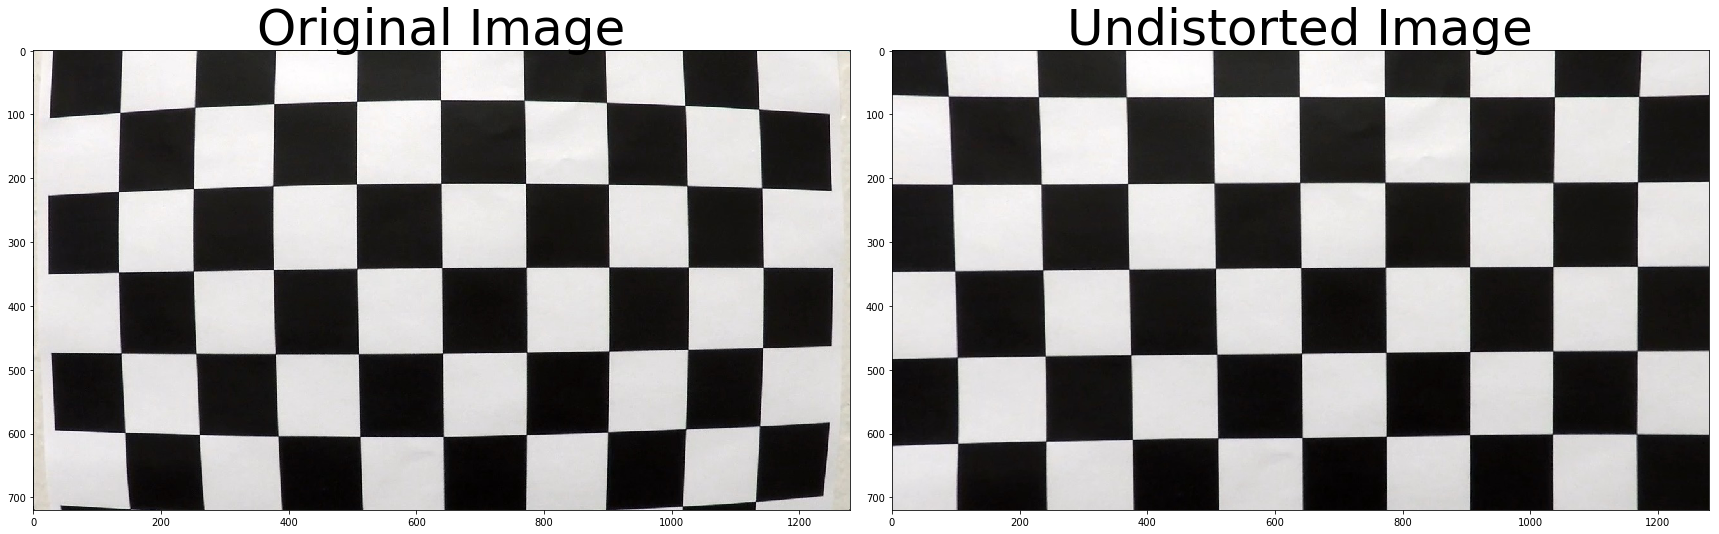

In [3]:
def undistort(image):
    """Undistort the given image based on the maxtrix and 
       distort coeffient above calculated by camera calibration.
    """
    res = cv2.undistort(image, mtx, dist, None, mtx)
    return res
img = mping.imread('./camera_cal/calibration1.jpg')
dst = undistort(img)

# Plot the raw image and the undistorted image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
fig.tight_layout()
ax1.imshow(img)
ax2.imshow(dst)
ax1.set_title('Original Image', fontsize=50)
ax2.set_title('Undistorted Image', fontsize=50)

## Use color transforms, gradients, etc., to create a thresholded binary image

Text(0.5,1,'Undistorted Image')

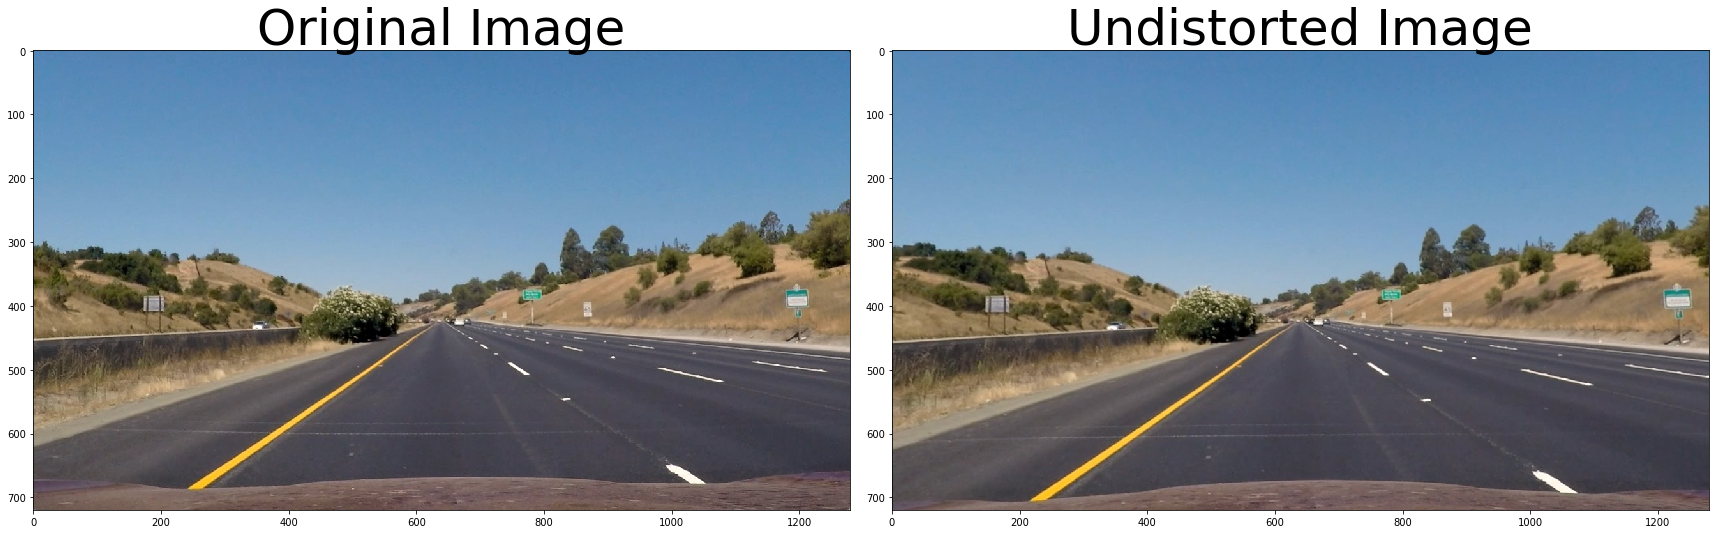

In [4]:
# Test the unditort function to a road img
road_img = mping.imread("./test_images/straight_lines1.jpg")
road_dst = undistort(road_img)
# Plot the raw image and the undistorted image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
fig.tight_layout()
ax1.imshow(road_img)
ax2.imshow(road_dst)
ax1.set_title('Original Image', fontsize=50)
ax2.set_title('Undistorted Image', fontsize=50)


## Use color transforms, gradients, etc., to create a thresholded binary image

This combination works well even in some tricky cases.


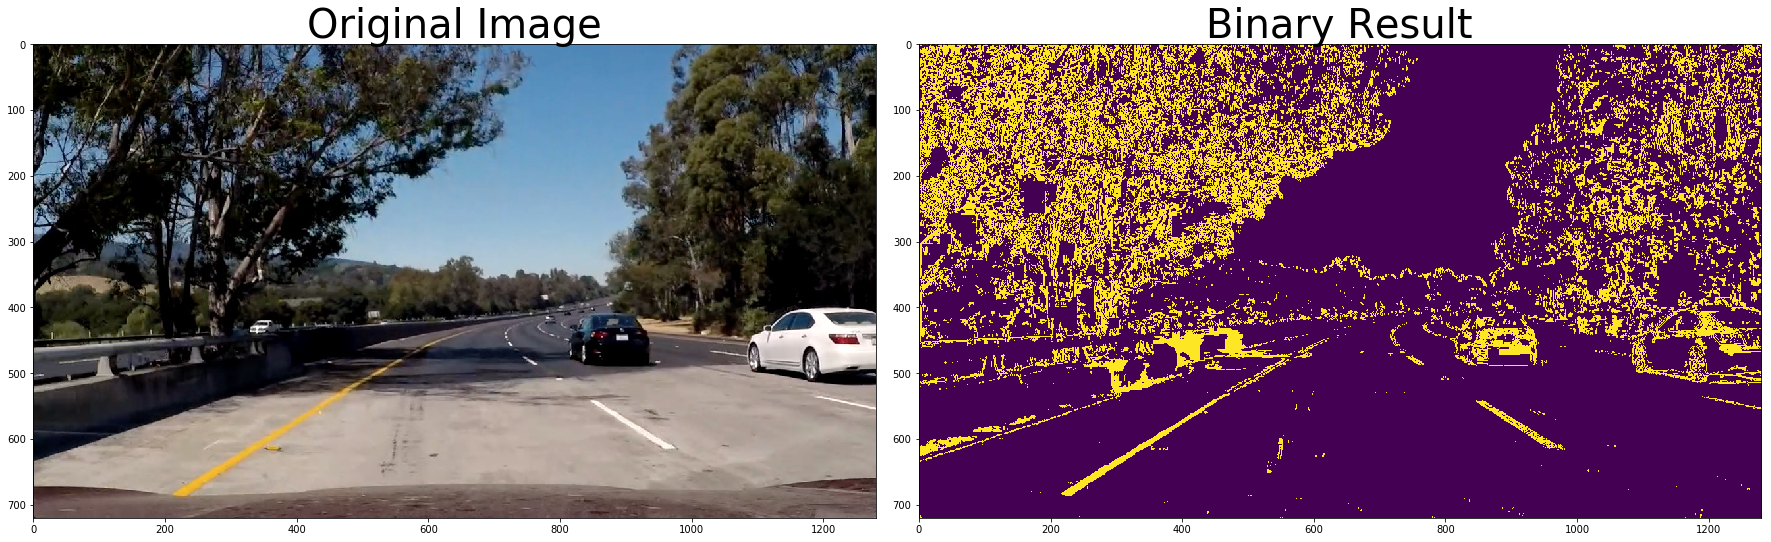

In [5]:
def thresh_to_binary(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    """Combin the S channel (in HSL color channerl) threshold and x-direction gradient threshold"""
    # hls 
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # sober x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold S color channel
    schannel_binary = np.zeros_like(s_channel)
    schannel_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Threshold x gradient
    soberx_binary = np.zeros_like(scaled_sobel)
    soberx_binary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    # combine two treshold
    combined_binary = np.zeros_like(soberx_binary)
    combined_binary[(schannel_binary == 1) | (soberx_binary == 1)] = 1
    return combined_binary


# Test this thresh_to_binary() funciton. 
example_image = mpimg.imread("./test_images/test5.jpg")
bin_image = thresh_to_binary(example_image)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(example_image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(bin_image)
ax2.set_title('Binary Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
print("This combination works well even in some tricky cases.")

## Apply a perspective transform to rectify binary image ("birds-eye view").

In [6]:
H,W = example_image.shape[0:2]
# A possible pair of source points and destination points.
SRC = np.float32([(575,464),
                  (707,464), 
                  (258,682), 
                  (1049,682)])
# change this DST_UPPER, extend the lane line in the far side.
# This part has an additional effect: mask.
DST_UPPER = 100
DST = np.float32([(450,DST_UPPER),
                  (W-450,DST_UPPER),
                  (450,H),
                  (W-450,H)])
def trans_perspective(img, src=SRC, dst=DST):
    """Transform a image to bird view. We assume the groud is flat and the camera perspective keeps the same."""
    h, w = img.shape[0:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # use cv2.warpPerspective() to warp image to bird view
    warped = cv2.warpPerspective(img, M, (w, h), flags=cv2.INTER_LINEAR)
    return warped

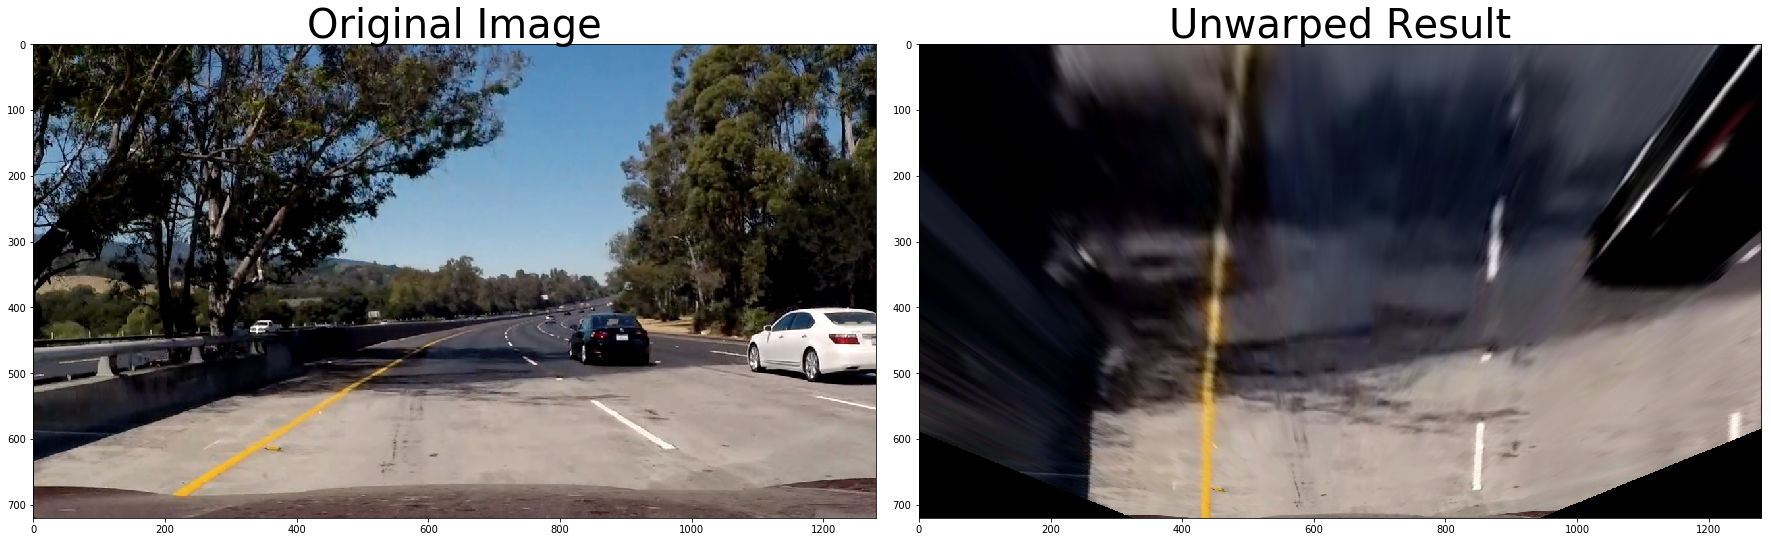

In [7]:
# Visualize perspective transformation
example_image = mpimg.imread("./test_images/test5.jpg")
unwarped_image = trans_perspective(example_image)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(example_image)
# ax1.plot(1049, 682, 'o')
# ax1.plot(575, 464, 'o')
# ax1.plot(575, 464, 'o')
# ax1.plot(575, 464, 'o')
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(unwarped_image)
ax2.set_title('Unwarped Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Detect lane pixels and fit to find the lane boundary.

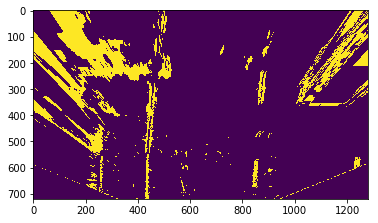

In [12]:
binary_warped = thresh_to_binary(unwarped_image)
plt.imshow(binary_warped)

In [13]:
# unwarped_binary_image.shape[0]//2: only consider the lower part 
# Although there is a peak around 200 (shadow), the width of the bounding box will take care of this.
histogram = np.sum(unwarped_binary_image[binary_warped.shape[0]//2:,:], axis=0)
# histogram = np.sum(unwarped_binary_image[0:,:], axis=0)
plt.plot(histogram)
# print(unwarped_binary_image.shape)

NameError: name 'unwarped_binary_image' is not defined

In [21]:
"""Input a binary img which lane lines have been extrated. Do a polynomial fit and return the results."""

def polyfit_binary(binary_warped):
    # Take a histogram of the bottom half of the image
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # cv2.circle(out_img,(leftx_base,720),10,(55,255,155),8)
    # Choose the number of sliding windows
    nwindows = 18
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    # nonzero[0]: nonzero pixel's x value; nonzero[1]: nonzero pixel's y value
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin. Width of the margin: margin*2
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Tuple to store rectange vertices
    rectangles = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        rectangles.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))

        # Identify the nonzero pixels in x and y within the window
        # All the nonzero pixels' x value in the current window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit, nonzero,left_lane_inds, right_lane_inds, rectangles

(720, 0)

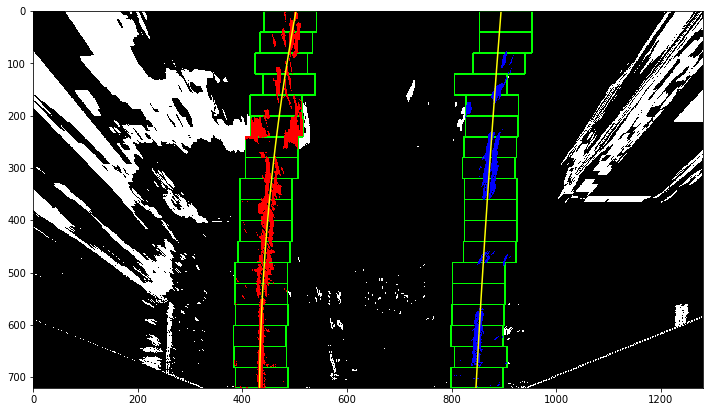

In [22]:
left_fit, right_fit, nonzero, left_lane_inds, right_lane_inds, rectangles = polyfit_binary(binary_warped)

"""Draw the ploy fit results."""
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Draw the windows on the visualization image
for rectangle in rectangles:
    cv2.rectangle(out_img,(rectangle[2],rectangle[0]),(rectangle[3],rectangle[1]),(0,255,0), 2) 
    cv2.rectangle(out_img,(rectangle[4],rectangle[0]),(rectangle[5],rectangle[1]),(0,255,0), 2) 


# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
# red all the valid left lane pixels, blue all the valid right lane pixels.
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

plt.figure(0, figsize=(12,8))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [50]:
def polyfit_binary_post(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fit, right_fit, nonzero,left_lane_inds, right_lane_inds

(720, 0)

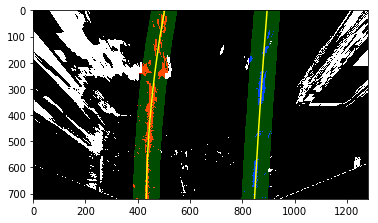

In [51]:
"""Draw the result of polyfit post"""
margin = 50

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Draw the detected lane back to the original image

In [42]:
def draw_lane(example_image, left_fit, right_fit, src=SRC, dst=DST):
    new_img = np.copy(example_image)
    if left_fit is None or right_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(example_image[:,:,0]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h, w = example_image.shape[0:2]
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
#     cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    Minv = cv2.getPerspectiveTransform(dst, src)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

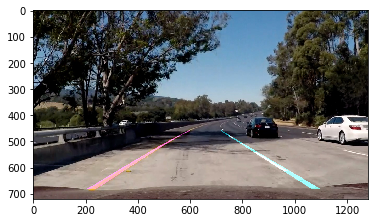

In [43]:
exampleImg_out1 = draw_lane(example_image, left_fit, right_fit)
plt.imshow(exampleImg_out1)

### Write curve radius and distance to centre data on the image

In [ ]:
def write_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

In [54]:
def cal_curve_r(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048/100 # meters per pixel in y dimension
    xm_per_pix = 3.7/378 # meters per pixel in x dimension
    
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    y_eval = np.max(ploty)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    return left_curverad, right_curverad


In [55]:
cal_curve_r(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds)

392.4461612264114 m 2693.238961796078 m


(392.4461612264114, 2693.238961796078)

In [58]:
def cal_dist_to_centre(binary_warped, left_fit, right_fit):
    if right_fit is not None and left_fit is not None:
        h = binary_warped.shape[0]
        car_position = binary_warped.shape[1]/2
        l_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
        r_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        xm_per_pix = 3.7/378 # meters per pixel in x dimension
        center_dist = (car_position - lane_center_position) * xm_per_pix
        return center_dist

In [59]:
cal_dist_to_centre(binary_warped, left_fit, right_fit)

0.001987071909415708